Importar librerias requeridas

In [1]:
import ee 
import geemap
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Autenticación con GEE y extracción de zona de estudio

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-rimartinezs')

In [3]:
with open(os.path.join(os.getcwd(), '..', 'data', 'Localidad_Usme.geojson')) as geojson:
    data = json.load(geojson)

zona_estudio = ee.FeatureCollection(data)

In [4]:
Sen2Collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(zona_estudio) \
    .filterDate('2023-01-01', '2023-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)) \
    .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'])

def recortar(img):
    return img.clip(zona_estudio)
aoi_Sen2Collection = Sen2Collection.map(recortar)

# Calcular área total una sola vez
area_total = zona_estudio.geometry().area().getInfo()

# Filtrar imágenes con >95% de cobertura y guardar resultados
imagenes = aoi_Sen2Collection.toList(aoi_Sen2Collection.size())
resultados = []
imagenes_filtradas_ee = []
for i in range(aoi_Sen2Collection.size().getInfo()):
    img = ee.Image(imagenes.get(i))
    img_id = img.id().getInfo()
    mascara_valida = img.select(0).mask().gt(0)
    pix_area = ee.Image.pixelArea().updateMask(mascara_valida)
    area_cubierta = pix_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=zona_estudio.geometry(),
        scale=10,
        maxPixels=1e10
    ).get('area').getInfo()
    porcentaje_cobertura = (area_cubierta / area_total) * 100 if area_total > 0 else 0
    resultados.append({'id': img_id, 'area_cubierta': area_cubierta, 'porcentaje': porcentaje_cobertura})
    if porcentaje_cobertura >= 95:
        imagenes_filtradas_ee.append(img)

In [5]:
# Mostrar resultados ordenados
for r in sorted(resultados, key=lambda x: x['porcentaje'], reverse=True):
    print(f"Imagen: {r['id']}, Área cubierta: {r['area_cubierta']:.2f} m², Porcentaje: {r['porcentaje']:.2f}%")

print("Imágenes con más del 95% de cobertura:")
for r in resultados:
    if r['porcentaje'] >= 95:
        print(f"Imagen: {r['id']}, Porcentaje: {r['porcentaje']:.2f}%")

Sen2_filtrado = ee.ImageCollection(imagenes_filtradas_ee)
print('Cantidad de imágenes con cobertura >95%:', Sen2_filtrado.size().getInfo())

# K-means sobre la primera imagen filtrada
primera_img = ee.Image(Sen2_filtrado.first())
bandas = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']  
img_clasif = primera_img.select(bandas)
num_clusters = 8
num_pixels = 5000
seed = 0
training = img_clasif.sample(
    region=zona_estudio.geometry(),
    scale=10,
    numPixels=num_pixels,
    seed=seed,
    geometries=True
)

clusterer = ee.Clusterer.wekaKMeans(num_clusters, seed).train(training)
resultado = img_clasif.cluster(clusterer)


Imagen: 20230128T152639_20230128T152835_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230202T152641_20230202T152642_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230503T152641_20230503T153004_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230518T152639_20230518T152642_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230826T152639_20230826T153029_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230831T152641_20230831T152943_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230207T152639_20230207T152901_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230403T152641_20230403T152638_T18NWK, Área cubierta: 207435705.10 m², Porcentaje: 96.11%
Imagen: 20230128T152639_20230128T152835_T18NWL, Área cubierta: 64947578.19 m², Porcentaje: 30.09%
Imagen: 20230202T152641_20230202T152642_T18NWL, Área cubierta: 64947578.19 m², Porcentaje: 30.09%
Imagen: 2023

In [9]:
palette = [
    '#b2babb', '#b2babb', '#ffe119', '#b2babb', 
    '#b2babb', '#b2babb', '#b2babb', '#b2babb'
]
Map = geemap.Map()
Map.centerObject(zona_estudio, 12)
Map.addLayer(primera_img, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Imagen original')
Map.addLayer(resultado, {'min': 0, 'max': num_clusters-1, 'palette': palette}, 'K-means (8 clases)')
Map.addLayer(zona_estudio, {}, 'Zona de estudio')
Map.addLayerControl()
Map


Map(center=[4.390019031052832, -74.14281202673868], controls=(WidgetControl(options=['position', 'transparent_…

In [7]:
# 1. Cluster sobre la primera imagen
primera_img = ee.Image(Sen2_filtrado.first())
img_clasif = primera_img.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'])
cluster_img = img_clasif.cluster(clusterer)

# 2. Extrae solo el cluster 2 como máscara
cluster2_mask = cluster_img.eq(2)

# 3. Vectoriza solo el cluster 2
cluster2_vector = cluster2_mask.selfMask().reduceToVectors(
    geometry=zona_estudio.geometry(),
    scale=10,
    geometryType='polygon',
    labelProperty='cluster',
    maxPixels=1e13
)

# 4. Estadísticas solo sobre el polígono del cluster 2
imagenes = Sen2_filtrado.toList(Sen2_filtrado.size())
n_imagenes = Sen2_filtrado.size().getInfo()
resultados_indices = []

for i in range(n_imagenes):
    img = ee.Image(imagenes.get(i))
    img_id = img.id().getInfo()
    fecha = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    
    # Escala a reflectancia
    nir = img.select('B8').divide(10000)
    red = img.select('B4').divide(10000)
    green = img.select('B3').divide(10000)
    
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    gndvi = nir.subtract(green).divide(nir.add(green)).rename('GNDVI')
    evi2 = nir.subtract(red).multiply(2.5).divide(nir.add(red.multiply(2.4)).add(1)).rename('EVI2')
    
    indices = ndvi.addBands([gndvi, evi2])
    stats = indices.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=cluster2_vector.geometry(),
        scale=10,
        maxPixels=1e13
    ).getInfo()
    
    resultados_indices.append({
        'imagen_id': img_id,
        'date': fecha,
        'NDVI_mean': stats.get('NDVI'),
        'GNDVI_mean': stats.get('GNDVI'),
        'EVI2_mean': stats.get('EVI2')
    })



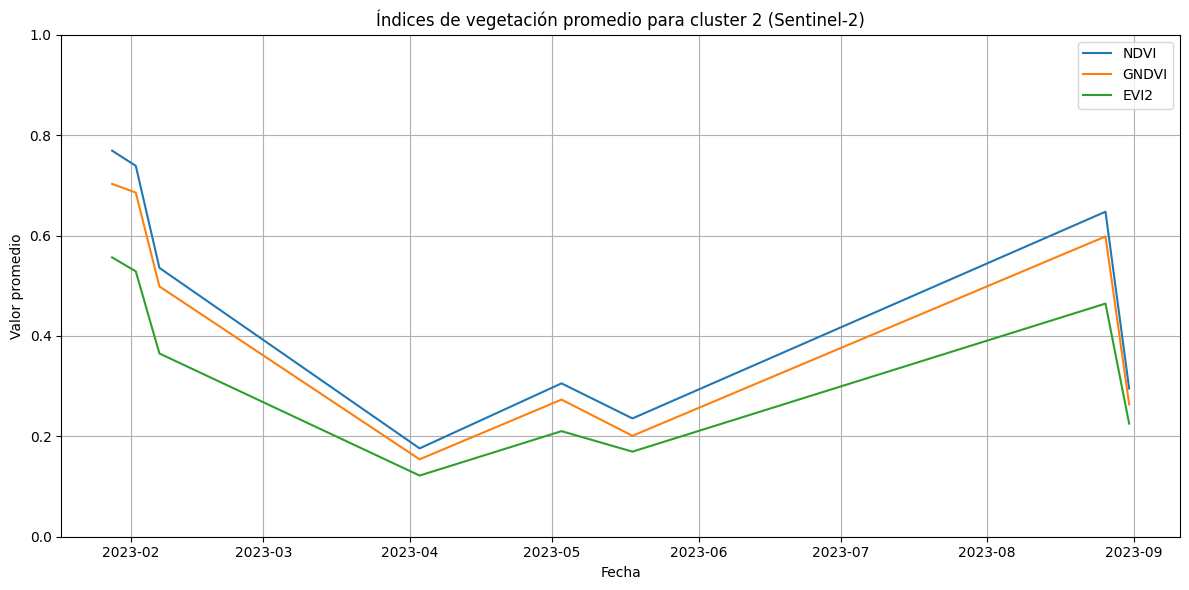

In [8]:
# Convertir a DataFrame y graficar
df = pd.DataFrame(resultados_indices)
df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['NDVI_mean'], label='NDVI')
plt.plot(df['date'], df['GNDVI_mean'], label='GNDVI')
plt.plot(df['date'], df['EVI2_mean'], label='EVI2')
plt.title('Índices de vegetación promedio para cluster 2 (Sentinel-2)')
plt.xlabel('Fecha')
plt.ylabel('Valor promedio')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()